# LSTM Model: 4 Timesteps

## Packages

In [2]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

from keras.layers import LSTM
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout

import matplotlib.pyplot as plt
from math import sqrt

## Prep Data for LSTM

In [3]:
pirates = pd.read_csv('data/pirates2.csv')

In [4]:
pirates.head(2)

,datetime,wait_time,WDWMAXTEMP,WDWMINTEMP,WDWMEANTEMP,inSession,MKHOURSEMH,WEATHER_WDWPRECIP,MKPRDDAY,MKPRDNGT,...,MONTH_Nov,MONTH_Oct,MONTH_Sep,DAY_Friday,DAY_Monday,DAY_Saturday,DAY_Sunday,DAY_Thursday,DAY_Tuesday,DAY_Wednesday
0,2016-01-01 08:07:00,5.0,82.73,67.78,75.26,0.0,18.0,0.12,2,1,...,0,0,0,1,0,0,0,0,0,0
1,2016-01-01 08:14:00,5.0,82.73,67.78,75.26,0.0,18.0,0.12,2,1,...,0,0,0,1,0,0,0,0,0,0


In [5]:
pirates['datetime'] = pd.to_datetime(pirates['datetime'])

### Split into Train/Test/Validate

train - year 2016-2017

test - year 2018

validate - year 2019

In [6]:
train = pirates.loc[(pirates['datetime'].dt.year >= 2016) & (pirates['datetime'].dt.year <= 2017)]
test = pirates[(pirates['datetime'].dt.year==2018)]
val = pirates[(pirates['datetime'].dt.year==2019)]

In [7]:
print(train.shape)
print(test.shape)
print(val.shape)

(91006, 53)
(53990, 53)
(49233, 53)


In [8]:
#set datetime as the index
train = train.set_index('datetime')
test = test.set_index('datetime')
val = val.set_index('datetime')

In [9]:
train.head()

,wait_time,WDWMAXTEMP,WDWMINTEMP,WDWMEANTEMP,inSession,MKHOURSEMH,WEATHER_WDWPRECIP,MKPRDDAY,MKPRDNGT,SUNSET_HOUR_17,...,MONTH_Nov,MONTH_Oct,MONTH_Sep,DAY_Friday,DAY_Monday,DAY_Saturday,DAY_Sunday,DAY_Thursday,DAY_Tuesday,DAY_Wednesday
datetime,,,,,,,,,,,,,,,,,,,,,
2016-01-01 08:07:00,5.0,82.73,67.78,75.26,0.0,18.0,0.12,2,1,1,...,0,0,0,1,0,0,0,0,0,0
2016-01-01 08:14:00,5.0,82.73,67.78,75.26,0.0,18.0,0.12,2,1,1,...,0,0,0,1,0,0,0,0,0,0
2016-01-01 08:21:00,5.0,82.73,67.78,75.26,0.0,18.0,0.12,2,1,1,...,0,0,0,1,0,0,0,0,0,0
2016-01-01 08:27:00,5.0,82.73,67.78,75.26,0.0,18.0,0.12,2,1,1,...,0,0,0,1,0,0,0,0,0,0
2016-01-01 08:29:00,5.0,82.73,67.78,75.26,0.0,18.0,0.12,2,1,1,...,0,0,0,1,0,0,0,0,0,0


### Scale the Data

In [10]:
scaler = MinMaxScaler(feature_range=(0, 1))

In [11]:
def scale_data(data):
    """Function to transform df into scaled data. Returns a numpy array."""
    
    # create array of values
    values = data.values
    # normalize features
    values = values.astype('float32')
    
    scaled = scaler.fit_transform(values)
    return scaled

In [12]:
train_scaled = scale_data(train)
test_scaled = scale_data(test)
val_scaled = scale_data(val)

In [13]:
train_scaled

array([[0.04      , 0.694064  , 0.72962403, ..., 0.        , 0.        ,
        0.        ],
       [0.04      , 0.694064  , 0.72962403, ..., 0.        , 0.        ,
        0.        ],
       [0.04      , 0.694064  , 0.72962403, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.08000001, 0.38698626, 0.22755927, ..., 0.        , 0.        ,
        0.        ],
       [0.08000001, 0.38698626, 0.22755927, ..., 0.        , 0.        ,
        0.        ],
       [0.08000001, 0.38698626, 0.22755927, ..., 0.        , 0.        ,
        0.        ]], dtype=float32)

### Convert Time Series to Samples

Reframe the time series as a supervised learning. Generally time intervals are on average of every 7 minutes. I want to use the last 30 minutes of wait times to predict the next interval. This would mean take the 4 past events and 1 future event.

In [14]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [15]:
n_steps_past = 4
n_steps_future = 1
n_features = 52

# reframe for supervise
train_reframe = series_to_supervised(train_scaled, n_steps_past, n_steps_future)
test_reframe = series_to_supervised(test_scaled, n_steps_past, n_steps_future)
val_reframe = series_to_supervised(val_scaled, n_steps_past, n_steps_future)

In [16]:
train_reframe.head()

,var1(t-4),var2(t-4),var3(t-4),var4(t-4),var5(t-4),var6(t-4),var7(t-4),var8(t-4),var9(t-4),var10(t-4),...,var43(t),var44(t),var45(t),var46(t),var47(t),var48(t),var49(t),var50(t),var51(t),var52(t)
4,0.04,0.694064,0.729624,0.720009,0.0,1.0,0.28125,0.666667,0.5,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.04,0.694064,0.729624,0.720009,0.0,1.0,0.28125,0.666667,0.5,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.04,0.694064,0.729624,0.720009,0.0,1.0,0.28125,0.666667,0.5,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.04,0.694064,0.729624,0.720009,0.0,1.0,0.28125,0.666667,0.5,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.04,0.694064,0.729624,0.720009,0.0,1.0,0.28125,0.666667,0.5,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


### Split into input/output and reshape

Split the train, test, and val into features and labels.

In [17]:
n_obs_past = n_steps_past * n_features
n_obs_future = n_steps_future * n_features

In [18]:
train_X, train_y = train_reframe.iloc[:, :n_obs_past], train_reframe.iloc[:, -n_obs_future]
test_X, test_y = test_reframe.iloc[:, :n_obs_past], test_reframe.iloc[:, -n_obs_future]
val_X, val_y = val_reframe.iloc[:, :n_obs_past], val_reframe.iloc[:, -n_obs_future]

In [19]:
train_y

4        0.040
5        0.000
6        0.040
7        0.016
8        0.040
         ...  
91001    0.080
91002    0.080
91003    0.080
91004    0.080
91005    0.080
Name: var1(t), Length: 90255, dtype: float32

In [20]:
# get values in array

train_X, train_y = train_X.values, train_y.values
test_X, test_y = test_X.values, test_y.values
val_X, val_y = val_X.values, val_y.values

In [21]:
train_y

array([0.04      , 0.        , 0.04      , ..., 0.08000001, 0.08000001,
       0.08000001], dtype=float32)

In [22]:
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape, val_X.shape, val_y.shape)

(90255, 208) (90255,) (53986, 208) (53986,) (49120, 208) (49120,)


Reshape features vector into 3D.

In [23]:
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_steps_past, n_features))
test_X = test_X.reshape((test_X.shape[0], n_steps_past, n_features))
val_X = val_X.reshape((val_X.shape[0], n_steps_past, n_features))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape, val_X.shape, val_y.shape)

(90255, 4, 52) (90255,) (53986, 4, 52) (53986,) (49120, 4, 52) (49120,)


In [24]:
train_X

array([[[0.04      , 0.694064  , 0.72962403, ..., 0.        ,
         0.        , 0.        ],
        [0.04      , 0.694064  , 0.72962403, ..., 0.        ,
         0.        , 0.        ],
        [0.04      , 0.694064  , 0.72962403, ..., 0.        ,
         0.        , 0.        ],
        [0.04      , 0.694064  , 0.72962403, ..., 0.        ,
         0.        , 0.        ]],

       [[0.04      , 0.694064  , 0.72962403, ..., 0.        ,
         0.        , 0.        ],
        [0.04      , 0.694064  , 0.72962403, ..., 0.        ,
         0.        , 0.        ],
        [0.04      , 0.694064  , 0.72962403, ..., 0.        ,
         0.        , 0.        ],
        [0.04      , 0.694064  , 0.72962403, ..., 0.        ,
         0.        , 0.        ]],

       [[0.04      , 0.694064  , 0.72962403, ..., 0.        ,
         0.        , 0.        ],
        [0.04      , 0.694064  , 0.72962403, ..., 0.        ,
         0.        , 0.        ],
        [0.04      , 0.694064  , 0.7

## LSTM Model

### Model 1: LSTM: 50, Epochs: 100, BatchSize: 72

#### Create & Fit Model

In [25]:
# create the model
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 50)                20600     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 51        
Total params: 20,651
Trainable params: 20,651
Non-trainable params: 0
_________________________________________________________________


In [26]:
# fit the model
history = model.fit(train_X, train_y, epochs=100, batch_size=72, 
                    validation_data=(test_X, test_y), verbose=2, shuffle=False)


Train on 90255 samples, validate on 53986 samples
Epoch 1/100
 - 3s - loss: 0.0705 - val_loss: 0.1275
Epoch 2/100
 - 3s - loss: 0.0512 - val_loss: 0.0728
Epoch 3/100
 - 3s - loss: 0.0467 - val_loss: 0.0640
Epoch 4/100
 - 3s - loss: 0.0423 - val_loss: 0.0600
Epoch 5/100
 - 3s - loss: 0.0413 - val_loss: 0.0718
Epoch 6/100
 - 3s - loss: 0.0395 - val_loss: 0.0686
Epoch 7/100
 - 3s - loss: 0.0405 - val_loss: 0.0488
Epoch 8/100
 - 3s - loss: 0.0379 - val_loss: 0.0492
Epoch 9/100
 - 3s - loss: 0.0379 - val_loss: 0.0530
Epoch 10/100
 - 3s - loss: 0.0371 - val_loss: 0.0468
Epoch 11/100
 - 3s - loss: 0.0361 - val_loss: 0.0539
Epoch 12/100
 - 3s - loss: 0.0356 - val_loss: 0.0408
Epoch 13/100
 - 3s - loss: 0.0342 - val_loss: 0.0391
Epoch 14/100
 - 3s - loss: 0.0349 - val_loss: 0.0378
Epoch 15/100
 - 3s - loss: 0.0344 - val_loss: 0.0557
Epoch 16/100
 - 3s - loss: 0.0354 - val_loss: 0.0410
Epoch 17/100
 - 3s - loss: 0.0348 - val_loss: 0.0436
Epoch 18/100
 - 3s - loss: 0.0343 - val_loss: 0.0390
Epoc

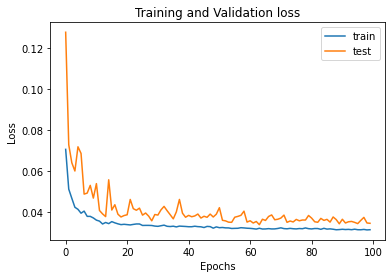

In [27]:
#Plot the loss 

plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

#### Predict on Test Data

In [30]:
# predict on test
yhat = model.predict(test_X)
model_test_X = test_X.reshape((test_X.shape[0], n_steps_past*n_features))

# invert scaling for forecast
inv_yhat = np.concatenate((yhat, model_test_X[:, -51:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]

# invert scaling for actual
model_test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((model_test_y, model_test_X[:, -51:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

In [31]:
inv_yhat

array([15.994302, 15.947887, 16.03016 , ..., 16.58292 , 16.58292 ,
       16.58292 ], dtype=float32)

In [32]:
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

# calculate MAE
mae = mean_absolute_error(inv_y, inv_yhat)
print('Test MAE: %.3f' % mae)

Test RMSE: 10.410
Test MAE: 6.218


### Model 2: LSTM: 50, Epochs: 100, BatchSize: 72

#### Create and fit the model

In [33]:
# create the model
model2 = Sequential()
model2.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model2.add(Dropout(.1))
model2.add(Dense(1))
model2.compile(loss='mae', optimizer='adam')
model2.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 50)                20600     
_________________________________________________________________
dropout_1 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 51        
Total params: 20,651
Trainable params: 20,651
Non-trainable params: 0
_________________________________________________________________


In [34]:
# fit the model
history2 = model2.fit(train_X, train_y, epochs=100, batch_size=72, 
                    validation_data=(test_X, test_y), verbose=2, shuffle=False)

Train on 90255 samples, validate on 53986 samples
Epoch 1/100
 - 3s - loss: 0.0802 - val_loss: 0.0828
Epoch 2/100
 - 3s - loss: 0.0522 - val_loss: 0.0670
Epoch 3/100
 - 3s - loss: 0.0451 - val_loss: 0.0480
Epoch 4/100
 - 3s - loss: 0.0407 - val_loss: 0.0508
Epoch 5/100
 - 3s - loss: 0.0397 - val_loss: 0.0467
Epoch 6/100
 - 3s - loss: 0.0387 - val_loss: 0.0454
Epoch 7/100
 - 3s - loss: 0.0387 - val_loss: 0.0442
Epoch 8/100
 - 3s - loss: 0.0379 - val_loss: 0.0435
Epoch 9/100
 - 3s - loss: 0.0372 - val_loss: 0.0458
Epoch 10/100
 - 3s - loss: 0.0373 - val_loss: 0.0437
Epoch 11/100
 - 3s - loss: 0.0363 - val_loss: 0.0430
Epoch 12/100
 - 3s - loss: 0.0369 - val_loss: 0.0427
Epoch 13/100
 - 3s - loss: 0.0361 - val_loss: 0.0533
Epoch 14/100
 - 3s - loss: 0.0363 - val_loss: 0.0523
Epoch 15/100
 - 3s - loss: 0.0356 - val_loss: 0.0440
Epoch 16/100
 - 3s - loss: 0.0359 - val_loss: 0.0423
Epoch 17/100
 - 3s - loss: 0.0356 - val_loss: 0.0400
Epoch 18/100
 - 3s - loss: 0.0354 - val_loss: 0.0424
Epoch

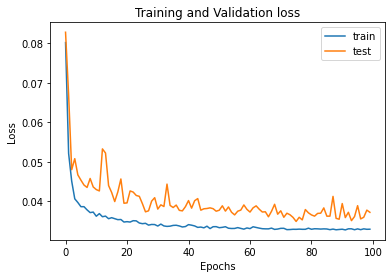

In [35]:
#Plot the loss 

plt.plot(history2.history['loss'], label='train')
plt.plot(history2.history['val_loss'], label='test')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

#### Predict on test data

In [37]:
# predict on test
yhat = model2.predict(test_X)
model2_test_X = test_X.reshape((test_X.shape[0], n_steps_past*n_features))

# invert scaling for forecast
inv_yhat = np.concatenate((yhat, model2_test_X[:, -51:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]

# invert scaling for actual
model2_test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((model2_test_y, model2_test_X[:, -51:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

# calculate MAE
mae = mean_absolute_error(inv_y, inv_yhat)
print('Test MAE: %.3f' % mae)

Test RMSE: 10.642
Test MAE: 6.704


### Model 3: LSTM: 50, Epochs: 50, BatchSize: 72

#### Create and fit the model

In [41]:
# create the model
model3 = Sequential()
model3.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model3.add(Dense(1))
model3.compile(loss='mae', optimizer='adam')

model3.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (None, 50)                20600     
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 51        
Total params: 20,651
Trainable params: 20,651
Non-trainable params: 0
_________________________________________________________________


In [42]:
# fit the model
history3 = model3.fit(train_X, train_y, epochs=50, batch_size=72, 
                    validation_data=(test_X, test_y), verbose=2, shuffle=False)

Train on 90255 samples, validate on 53986 samples
Epoch 1/50
 - 3s - loss: 0.0760 - val_loss: 0.0866
Epoch 2/50
 - 3s - loss: 0.0480 - val_loss: 0.0674
Epoch 3/50
 - 3s - loss: 0.0437 - val_loss: 0.0489
Epoch 4/50
 - 3s - loss: 0.0396 - val_loss: 0.0590
Epoch 5/50
 - 3s - loss: 0.0398 - val_loss: 0.0554
Epoch 6/50
 - 3s - loss: 0.0385 - val_loss: 0.0554
Epoch 7/50
 - 3s - loss: 0.0384 - val_loss: 0.0476
Epoch 8/50
 - 3s - loss: 0.0375 - val_loss: 0.0506
Epoch 9/50
 - 3s - loss: 0.0367 - val_loss: 0.0432
Epoch 10/50
 - 3s - loss: 0.0366 - val_loss: 0.0411
Epoch 11/50
 - 3s - loss: 0.0360 - val_loss: 0.0433
Epoch 12/50
 - 3s - loss: 0.0356 - val_loss: 0.0496
Epoch 13/50
 - 3s - loss: 0.0351 - val_loss: 0.0439
Epoch 14/50
 - 3s - loss: 0.0357 - val_loss: 0.0423
Epoch 15/50
 - 3s - loss: 0.0349 - val_loss: 0.0432
Epoch 16/50
 - 3s - loss: 0.0344 - val_loss: 0.0415
Epoch 17/50
 - 3s - loss: 0.0343 - val_loss: 0.0394
Epoch 18/50
 - 3s - loss: 0.0342 - val_loss: 0.0408
Epoch 19/50
 - 3s - los

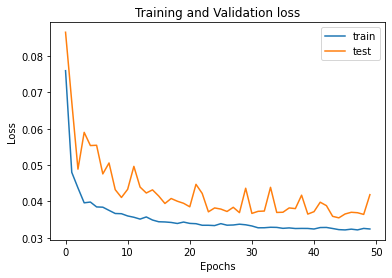

In [43]:
#Plot the loss 

plt.plot(history3.history['loss'], label='train')
plt.plot(history3.history['val_loss'], label='test')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

#### Predict on test data

In [44]:
# predict on test
yhat = model3.predict(test_X)
model3_test_X = test_X.reshape((test_X.shape[0], n_steps_past*n_features))

# invert scaling for forecast
inv_yhat = np.concatenate((yhat, model3_test_X[:, -51:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]

# invert scaling for actual
model3_test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((model3_test_y, model3_test_X[:, -51:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

# calculate MAE
mae = mean_absolute_error(inv_y, inv_yhat)
print('Test MAE: %.3f' % mae)

Test RMSE: 11.084
Test MAE: 7.532


### Model 4: LSTM: 50, Epochs: 100, BatchSize: 150

#### Create and fit the model

In [45]:
# create the model
model4 = Sequential()
model4.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model4.add(Dense(1))
model4.compile(loss='mae', optimizer='adam')

model4.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_7 (LSTM)                (None, 50)                20600     
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 51        
Total params: 20,651
Trainable params: 20,651
Non-trainable params: 0
_________________________________________________________________


In [46]:
# fit the model
history4 = model4.fit(train_X, train_y, epochs=100, batch_size=150, 
                    validation_data=(test_X, test_y), verbose=2, shuffle=False)

Train on 90255 samples, validate on 53986 samples
Epoch 1/100
 - 2s - loss: 0.0895 - val_loss: 0.1772
Epoch 2/100
 - 2s - loss: 0.0712 - val_loss: 0.0825
Epoch 3/100
 - 2s - loss: 0.0593 - val_loss: 0.0946
Epoch 4/100
 - 2s - loss: 0.0477 - val_loss: 0.1124
Epoch 5/100
 - 2s - loss: 0.0461 - val_loss: 0.0652
Epoch 6/100
 - 2s - loss: 0.0421 - val_loss: 0.0542
Epoch 7/100
 - 2s - loss: 0.0422 - val_loss: 0.0775
Epoch 8/100
 - 2s - loss: 0.0382 - val_loss: 0.0745
Epoch 9/100
 - 2s - loss: 0.0406 - val_loss: 0.0530
Epoch 10/100
 - 2s - loss: 0.0395 - val_loss: 0.0451
Epoch 11/100
 - 2s - loss: 0.0389 - val_loss: 0.0557
Epoch 12/100
 - 2s - loss: 0.0395 - val_loss: 0.0568
Epoch 13/100
 - 2s - loss: 0.0391 - val_loss: 0.0473
Epoch 14/100
 - 2s - loss: 0.0393 - val_loss: 0.0507
Epoch 15/100
 - 2s - loss: 0.0381 - val_loss: 0.0439
Epoch 16/100
 - 2s - loss: 0.0373 - val_loss: 0.0429
Epoch 17/100
 - 2s - loss: 0.0371 - val_loss: 0.0590
Epoch 18/100
 - 2s - loss: 0.0365 - val_loss: 0.0497
Epoch

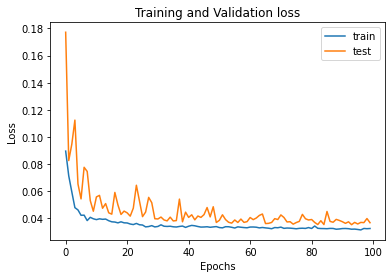

In [47]:
#Plot the loss 

plt.plot(history4.history['loss'], label='train')
plt.plot(history4.history['val_loss'], label='test')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

#### Predict on test data

In [48]:
# predict on test
yhat = model4.predict(test_X)
model4_test_X = test_X.reshape((test_X.shape[0], n_steps_past*n_features))

# invert scaling for forecast
inv_yhat = np.concatenate((yhat, model4_test_X[:, -51:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]

# invert scaling for actual
model4_test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((model4_test_y, model4_test_X[:, -51:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

# calculate MAE
mae = mean_absolute_error(inv_y, inv_yhat)
print('Test MAE: %.3f' % mae)

Test RMSE: 10.670
Test MAE: 6.592


### Model 5: Two layers LSTM: 50, Epochs: 100, BatchSize: 72 with Dropout: .5

#### Create and fit the model

In [49]:
# create the model
model5 = Sequential()
model5.add(LSTM(50, return_sequences=True,input_shape=(train_X.shape[1], train_X.shape[2])))
model5.add(Dropout(.5))
model5.add(LSTM(50))
model5.add(Dense(1))
model5.compile(loss='mae', optimizer='adam')

model5.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_8 (LSTM)                (None, 4, 50)             20600     
_________________________________________________________________
dropout_3 (Dropout)          (None, 4, 50)             0         
_________________________________________________________________
lstm_9 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 51        
Total params: 40,851
Trainable params: 40,851
Non-trainable params: 0
_________________________________________________________________


In [50]:
# fit the model
history5 = model5.fit(train_X, train_y, epochs=100, batch_size=72, 
                    validation_data=(test_X, test_y), verbose=2, shuffle=False)

Train on 90255 samples, validate on 53986 samples
Epoch 1/100
 - 6s - loss: 0.0743 - val_loss: 0.0767
Epoch 2/100
 - 6s - loss: 0.0554 - val_loss: 0.0606
Epoch 3/100
 - 6s - loss: 0.0460 - val_loss: 0.0611
Epoch 4/100
 - 6s - loss: 0.0424 - val_loss: 0.0449
Epoch 5/100
 - 6s - loss: 0.0397 - val_loss: 0.0444
Epoch 6/100
 - 6s - loss: 0.0385 - val_loss: 0.0426
Epoch 7/100
 - 6s - loss: 0.0380 - val_loss: 0.0453
Epoch 8/100
 - 6s - loss: 0.0378 - val_loss: 0.0408
Epoch 9/100
 - 6s - loss: 0.0372 - val_loss: 0.0424
Epoch 10/100
 - 6s - loss: 0.0371 - val_loss: 0.0414
Epoch 11/100
 - 6s - loss: 0.0368 - val_loss: 0.0450
Epoch 12/100
 - 6s - loss: 0.0361 - val_loss: 0.0388
Epoch 13/100
 - 6s - loss: 0.0361 - val_loss: 0.0420
Epoch 14/100
 - 6s - loss: 0.0365 - val_loss: 0.0387
Epoch 15/100
 - 6s - loss: 0.0357 - val_loss: 0.0408
Epoch 16/100
 - 6s - loss: 0.0362 - val_loss: 0.0392
Epoch 17/100
 - 6s - loss: 0.0356 - val_loss: 0.0419
Epoch 18/100
 - 6s - loss: 0.0355 - val_loss: 0.0405
Epoch

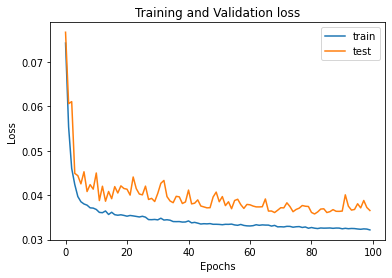

In [51]:
#Plot the loss 

plt.plot(history5.history['loss'], label='train')
plt.plot(history5.history['val_loss'], label='test')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

#### Predict on Test data

In [52]:
# predict on test
yhat = model5.predict(test_X)
model5_test_X = test_X.reshape((test_X.shape[0], n_steps_past*n_features))

# invert scaling for forecast
inv_yhat = np.concatenate((yhat, model5_test_X[:, -51:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]

# invert scaling for actual
model5_test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((model5_test_y, model5_test_X[:, -51:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

# calculate MAE
mae = mean_absolute_error(inv_y, inv_yhat)
print('Test MAE: %.3f' % mae)

Test RMSE: 10.516
Test MAE: 6.581


#### Resource:
Brownlee, Jason. (2017). Multivariate Time Series Forecasting with LSTMs in Keras. Retrieved from https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/